In [9]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
# %watermark -p numpy,sklearn,pandas
# %watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
# %watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# %config IPCompleter.use_jedi = False

# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x):
    try:
        x = x.strip()
        if x[0] == '/' or x[1] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                x = 'https://' + x
                x = requests.get(x)
                if x.status_code == 200:
                    x = x.text
            elif x.startswith('github.com'):
                x = x.replace('github.com', 'raw.githubusercontent.com')
                mod = x.split('/')
                for s in ['/main/', '/master/']:
                    x = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[-3:])
                    x = requests.get(x)
                    if x.status_code == 200:
                        x = x.text
                        break
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                for s in ['/raw/main/', '/raw/master/']:
                    x = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[3:])
                    x = requests.get(x)
                    if x.status_code == 200:
                        x = x.text
                        break
        exec(x, globals())
    except Exception as err:
        # sys.stderr.write(f'request {x} : {err}')
        pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)

###
### Display ###
###

_IMPORT('import pandas as pd')
_IMPORT('import cv2')
_IMPORT('from PIL import Image')
_IMPORT('import matplotlib.pyplot as plt')
_IMPORT('import plotly')
_IMPORT('import plotly.graph_objects as go')
_IMPORT('import ipywidgets as widgets')
_IMPORT('from ipywidgets import interact, interactive, fixed, interact_manual')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

def show_image(imgsrc, width=None, height=None, rgb=True):
    if isinstance(imgsrc, np.ndarray):
        img = imgsrc
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            if not rgb:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if imgsrc.startswith('http'):
        data_url = imgsrc
    else:
        if len(imgsrc) > 2048:
            data_url = 'data:image/jpg;base64,' + imgsrc
        else:
            img = open(imgsrc, 'rb').read()
            data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<center><img %s %s src="%s"/></center>' % (W, H, data_url))

def im_read(url, rgb=True, size=None):
    if url.startswith('http'):
        response = requests.get(url)
        if response:
            imgmat = np.frombuffer(response.content, dtype=np.uint8)
            img = cv2.imdecode(imgmat, cv2.IMREAD_COLOR)
        else:
            return None
    else:
        img = cv2.imread(url)
        
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if size:
        if isinstance(size, int):
            size = (size, size)
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img


## TEST

In [ ]:
dict_id = cv2.aruco.Dictionary_get(cv2.aruco.DICT_7X7_1000)

100.0 100.0


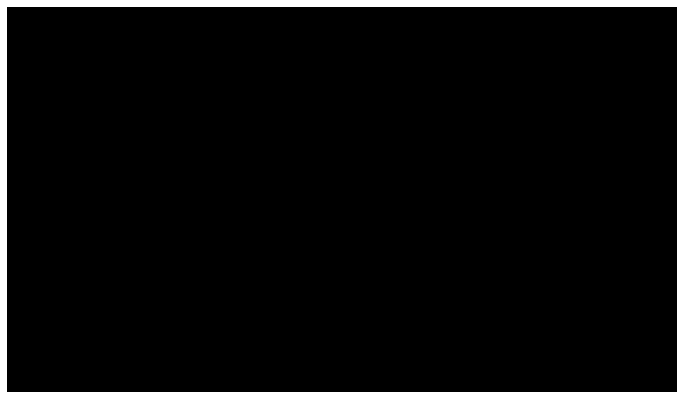

In [117]:
# tag_file = 'db3-aruco.png'
# test_file = 'db3-test-1.mp4'
# out_file = 'db3-out-1.mp4'

tag_file = 'e8b-aruco.png'
test_file = 'e8b-test-1.mp4'
out_file = 'e8b-out-1.mp4'

pixel_cm_ratio = 1
db3_tag_img = cv2.imread(f'aruco/{tag_file}')
marker_corners, marker_ids, _ = cv2.aruco.detectMarkers(db3_tag_img, dict_id)
for (marker_corner, marker_id) in zip(marker_corners, marker_ids):
    pixel_cm_ratio = cv2.arcLength(marker_corner[0], True) / (4 *  marker_id[0])
    min_rect = cv2.minAreaRect(marker_corner[0])
    (c_x, c_y), (m_w, m_h), angle = min_rect
    box = np.int0(cv2.boxPoints(min_rect))
    tri_width = m_w / pixel_cm_ratio
    tri_height = m_h / pixel_cm_ratio
    print(tri_width, tri_height)

assert pixel_cm_ratio != 1

cap = cv2.VideoCapture(f'./aruco/{test_file}')
fps = round(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

ret, frame = cap.read()
show_image(frame, rgb=False)

lower_red = np.array([0, 0, 200], dtype = "uint8") 
upper_red= np.array([0, 0, 255], dtype = "uint8")

pixel_cm_ratio

writer = cv2.VideoWriter(f'./aruco/{out_file}', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

cur_w, cur_h = 0.0, 0.0

while True:
    ret, image = cap.read()
    if not ret:
        break 
        
    mask = cv2.inRange(image, lower_red, upper_red)
    show_image(mask)   
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    points = []
    for c in contours:
        area = cv2.contourArea(c)
        if area > 50:
            print('area', area)
            continue
        (cx, cy), (w, h), angle = cv2.minAreaRect(c)
        points.append((cx, cy))
    if len(points) == 4:
        cx, cy, w, h = cv2.boundingRect(np.int0(np.array(points)))
        cv2.drawContours(image, contours, -1, (222, 24, 0), 1)
        cur_w = round(w / pixel_cm_ratio, 2)
        cur_h = round(h / pixel_cm_ratio, 2)
    cv2.putText(image, f'width: {cur_w}mm, height: {cur_h}mm', (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (222, 24, 0), 2)
    writer.write(image)
        
cap.release()
writer.release()

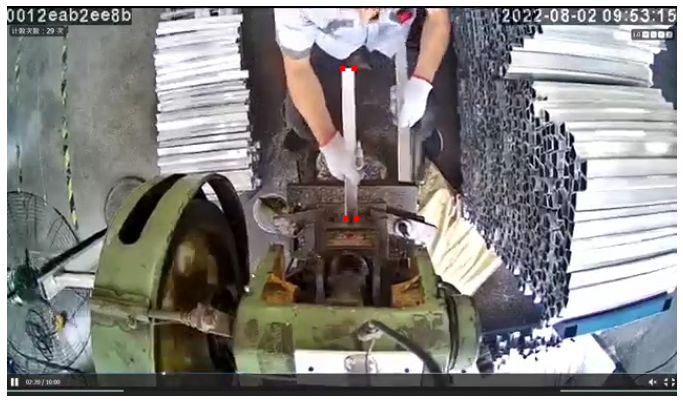

In [81]:
# image = cv2.imread('1287927748.jpg') 
image = cv2.imread('755636727.jpg') # db3
image = cv2.imread('e8b.jpg')
show_image(image, rgb=False)

In [82]:
lower_red = np.array([0, 0, 200], dtype = "uint8") 
upper_red= np.array([0, 0, 255], dtype = "uint8")

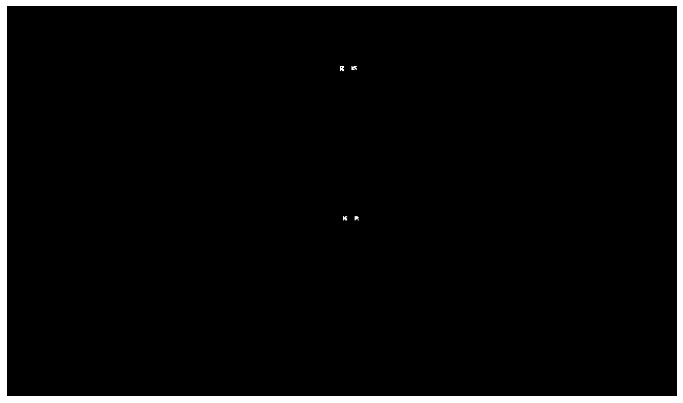

In [83]:
mask = cv2.inRange(image, lower_red, upper_red)
show_image(mask)

[(332.5, 201.5), (321.5, 201.5), (330.0, 58.5), (318.5, 59.0)]


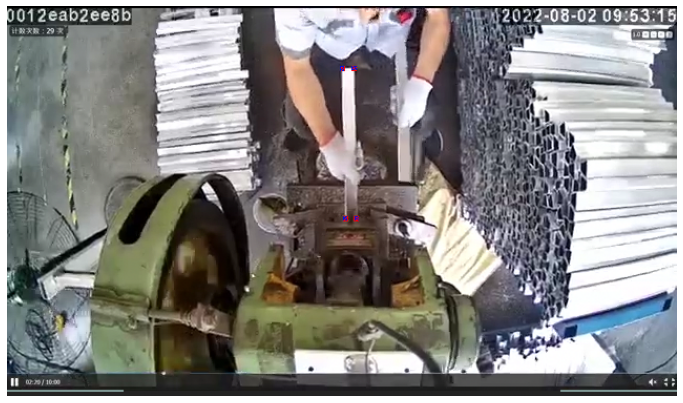

In [84]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
points = []
for c in contours:
    area = cv2.contourArea(c)
    if area > 50:
        continue
    # print(area)
    (cx, cy), (w, h), angle = cv2.minAreaRect(c)
    points.append((cx, cy))
print(points)
img = image.copy()
cv2.drawContours(img, contours, -1, (222, 24, 0), 1)
show_image(img, rgb=False)

In [85]:
a = np.int0(np.array(points))
cx, cy, w, h = cv2.boundingRect(a)
print(round(w /pixel_cm_ratio, 2), round(h / pixel_cm_ratio, 2))

44.38 426.06


In [87]:
pixel_cm_ratio

0.3379819965362549

In [38]:
# detected_output = cv2.bitwise_and(image, image, mask =  mask) 
# show_image(detected_output, rgb=False)